# 0. Import the data from huggingface

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json # mark: add this line
import pandas as pd


In [ ]:
dataset.data

{'train': MemoryMappedTable
 text: string
 label: int64
 ----
 text: [["i didnt feel humiliated","i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake","im grabbing a minute to post i feel greedy wrong","i am ever feeling nostalgic about the fireplace i will know that it is still on the property","i am feeling grouchy",...,"i should have been depressed but i was actually feeling inspired","i feel like not enough people my age actually think that most are pretty devastated that their s have come and gone","i get home i laze around in my pajamas feeling grouchy","i am feeling pretty homesick this weekend","i started out feeling really optimistic and driven for this paper coz it was gonna teach me the meaning and ways of being a leader"],["i need to do the best i possibly can do and even when i get out at i feel too listless to study like right now","i drove us to the car parts place and terry feels like im safe to drive again so yip

In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
dataset.column_names

{'train': ['text', 'label'],
 'validation': ['text', 'label'],
 'test': ['text', 'label']}

In [ ]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

### Note: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

In [ ]:
dataset['train'][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
dataset['train'][15999]

{'text': 'i know a lot but i feel so stupid because i can not portray it',
 'label': 0}

# 0. EDA

In [ ]:
# It’s easy to get high accuracy if one class is very common (just label everything as that class)
# In this case, precision and recall can be more useful
pd.Series(dataset['train'][:]['label']).value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
dtype: int64

## Which Evaluation Metrics to use:
Precision and Recall are particularly useful when there are more than two labels

Macro-average (average P/R of all classes):
Useful if performance on all classes is equally important.

Micro-average (average P/R of all items):
Useful if performance on all items is equally important.

f1 score can be a good metric too.

## Basic Info of Logistic classifier

A probabilistic classifier, as discriminative model,  returns the most likely class for input x:

$y^* = \text{argmax}_y P(Y = y \,|\, X = x)$

it only models the probability of the class given the input, and not of the raw data itself.

\\

Whereas naive bayes, as a generative model, models the joint distribution of the class and the data:

$y^* = \text{argmax}_y P(y \,|\, x) = \text{argmax}_y \left( P(x \,|\, y) P(y) \right)$

-> Sample/pick a label with P(y), and then an item x with P(x|y)

\\

Discriminative models draw boundaries in the data space, while generative models try to model how data is placed throughout the space. A generative model explains how the data was generated, while a discriminative model focuses on predicting the labels of the data.

The number of training examples required for a discriminative linear classifier to reach its asymptotic error is $O(n)$, where $n$ is the VC dimension. In contrast, the number of examples for a generative linear classifier is $O(\log{n})$.


-> *Andrew Y. Ng and Michael I. Jordan. 2001. On discriminative vs. generative classifiers: a comparison of logistic regression and naive Bayes. In Proceedings of the 14th International Conference on Neural Information Processing Systems: Natural and Synthetic (NIPS'01). MIT Press, Cambridge, MA, USA, 841–848.*

# 1. Logistic regression

In [ ]:
dataset['train'][0:4]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'],
 'label': [0, 0, 3, 2]}

In [ ]:
# we have X_train stores only text in the training ser
X_train = dataset['train'][:]['text'].copy()

In [ ]:
y_train = dataset['train'][:]['label'].copy()

In [ ]:
X_train[0:4]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property']

In [ ]:
y_train[0:4]

[0, 0, 3, 2]

## 1.1 CountVectorizer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
'''
parameter explanation:
stop_words = ''english'' -> remove “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text
min_df = 0.02 -> When building the vocabulary -> ignore terms that have a document frequency < 0.02
ngram_range = (1,1)
'''
vectorizer_try = CountVectorizer(stop_words='english',min_df=0.02, ngram_range=(1, 1))
X_try = vectorizer_try.fit_transform(X_train[0:4])
print('Data shape: ', X_try.shape)

Data shape:  (4, 20)


### Note:
why min_df = 0.02? Or How do we represent rarely appeared words?

**Option 1: the UNK token**

Replace all rare words (with a frequency at or below a given threshold, e.g. 2,
3, or 5) in your training data with an UNK token (UNK = “Unknown word”).  
Replace all unknown words that you come across after training (including rare
training words) with the same UNK token

**Option 2: substring-based representations**  
[often used in neural models]  
Represent (rare and unknown) words [“Champaign”] as sequences of
characters [‘C’, ‘h’, ‘a’,…,’g’, ’n'] or substrings [“Ch”, “amp”, “ai”, “gn”]

In [ ]:
vectorizer_try.get_feature_names_out()

array(['awake', 'cares', 'damned', 'didnt', 'feel', 'feeling',
       'fireplace', 'grabbing', 'greedy', 'hopeful', 'hopeless',
       'humiliated', 'im', 'just', 'know', 'minute', 'nostalgic', 'post',
       'property', 'wrong'], dtype=object)

In [ ]:
dense_matrix = pd.DataFrame(X_try.toarray(), columns=vectorizer_try.get_feature_names_out())
dense_matrix

,awake,cares,damned,didnt,feel,feeling,fireplace,grabbing,greedy,hopeful,hopeless,humiliated,im,just,know,minute,nostalgic,post,property,wrong
0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0


In [ ]:
# The function will generates a histogram to show how many unique words (from the vocabulary) are in each review
def review_word_count_histgram(X):
    '''
    X:  [# feature vectors, # features], feature vectors
    '''
    ### YOUR CODE STARTS HERE ###
    fig, axes = plt.subplots()

    dens = np.sum(X > 0, axis=1) # get unique word density for each comment
    axes.hist(dens, bins=30, edgecolor='black')
    axes.set_xlabel('Word counts', fontsize=14)

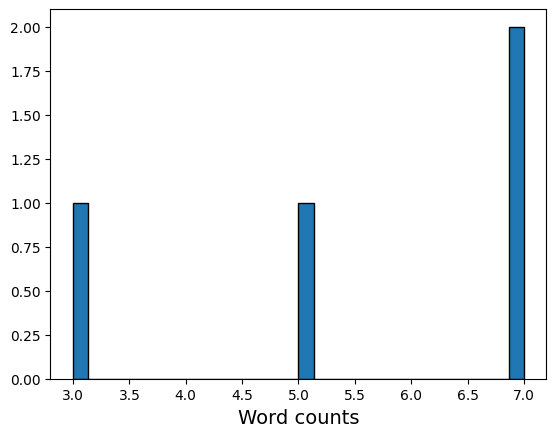

In [ ]:
review_word_count_histgram(X_try)
#
'''
Interpret:
there is 1 record has 3 unique words. (i didnt feel humiliated -> didnt, feel, humiliated)
there is 2 record has 7 unique words. ('im grabbing a minute to post i feel greedy wrong -> grabbing, minute, post, feel, greedy, wrong, im)
'''